In [1]:
import numpy as np
import pandas as pd

%matplotlib inline

In [4]:
ratings = pd.read_csv("data/hotel_rating.csv")
print("Number of hotels with TripAdvisor review ratings: {}".format(ratings.shape[0]))

Number of hotels with TripAdvisor review ratings: 2407


In [5]:
ratings.sample(5)

,destination_id,launch_date,launch_days,rating_average,rating_before_all,rating_after_all,rating_change_all,rating_before_1y,rating_after_1y,rating_change_1y,rating_before_ld,rating_after_ld,rating_change_ld
1847,10601363,2018-02-15 00:00:00,187,5.00000,NaN,5.00000,NaN,NaN,5.00000,NaN,NaN,5.00000,NaN
1318,662919,2017-11-25 00:00:00,269,4.16827,4.20202,3.50000,-0.70202,4.81250,3.50000,-1.31250,4.85714,3.50000,-1.35714
2249,193230,2018-05-01 00:00:00,112,3.42384,3.41065,3.77273,0.36207,3.67416,3.77273,0.09857,3.53846,3.77273,0.23427
2093,9776657,2018-03-31 00:00:00,143,4.50000,5.00000,4.00000,-1.00000,5.00000,4.00000,-1.00000,NaN,4.00000,NaN
1151,8147236,2017-10-30 00:00:00,295,4.41538,4.39894,4.45833,0.05940,4.37981,4.45833,0.07853,4.33908,4.45833,0.11925


In [6]:
from scipy import stats

rating_all = ratings[["rating_before_all", "rating_after_all"]].dropna()
stats.ttest_rel(rating_all["rating_after_all"], rating_all["rating_before_all"])

Ttest_relResult(statistic=2.9278832510358064, pvalue=0.00344939991654952)

##### The result of dependent t-test for paired samples shows that `rating_after_all` is greater than `rating_before_all` with 99% confidence level.

In [7]:
rating_1y = ratings[["rating_before_1y", "rating_after_1y"]].dropna()
stats.ttest_rel(rating_1y["rating_after_1y"], rating_1y["rating_before_1y"])

Ttest_relResult(statistic=0.7363916899012491, pvalue=0.46157584294064635)

In [8]:
rating_ld = ratings[["rating_before_ld", "rating_after_ld"]].dropna()
stats.ttest_rel(rating_ld["rating_after_ld"], rating_ld["rating_before_ld"])

Ttest_relResult(statistic=0.18483188009906443, pvalue=0.8533793741251862)

##### However, t-test for both (`rating_before_1y`, `rating_after_1y`) and (`rating_before_ld`, `rating_before_ld`) shows that although TripAdvisor review ratings for hotels after handy launch are greater than ratings before the launch (1y: reviews within (+/-) one year of launch; ld (launch days): reviews within T +/- days of handy launched), it is statistically insignificant to conclude so.

In [10]:
import psycopg2
import configparser

# Connect to the analytics database
config = configparser.ConfigParser()
config.read("connection.ini")
conn = psycopg2.connect(host=config["analytics"]["host"],
                        dbname=config["analytics"]["dbname"],
                        user=config["analytics"]["user"],
                        password=config["analytics"]["password"]
                       )

hotels = pd.read_sql("SELECT * FROM hotel;", con=conn)

In [11]:
hotels["price_min"] = hotels["price_range"].apply(lambda s: None if pd.isna(s) else float(s.split(" - ")[0].replace("HK$", "").replace(",", "")))
hotels["price_max"] = hotels["price_range"].apply(lambda s: None if pd.isna(s) else float(s.split(" - ")[1].replace("HK$", "").replace(",", "")))

In [12]:
hotels.sample(5)

,geo_id,destination_id,launch_date,name,address,review_count,hotel_class,price_range,lat,long,price_min,price_max
208,659630,3344617,2017-08-21,Asteras Resort,"Kardamena, Kardamena 853 02, Greece",531.0,4.0,"HK$534 - HK$2,056",36.782258,27.143523,534.0,2056.0
2322,274887,276385,2017-09-15,King's Hotel,"Nagy Diofa utca 25-27, Budapest 1072, Hungary",742.0,3.0,HK$314 - HK$824,47.498460,19.064335,314.0,824.0
1548,298570,302421,2018-01-17,InterContinental Kuala Lumpur,"165 Jalan Ampang, Kuala Lumpur 50450, Malaysia",2961.0,5.0,"HK$753 - HK$1,703",3.159738,101.717751,753.0,1703.0
2353,293797,2366763,2017-12-04,La Villa Boutique Hotel,"N. F56/1 13th Lane Osu Ringway, Accra 6856, Ghana",219.0,3.0,"HK$1,083 - HK$1,852",5.567029,-0.182602,1083.0,1852.0
587,187439,610840,2017-12-25,Gran Hotel Guadalpin Banus,"Calle Edgar Neville s/n | Nueva Andalucía, 296...",1047.0,5.0,"HK$887 - HK$5,659",36.483278,-4.966322,887.0,5659.0


In [13]:
data = hotels[["destination_id", "hotel_class", "price_min", "price_max"]].merge(ratings[["destination_id", "rating_before_all", "rating_before_1y", "rating_after_1y"]], how="inner", on="destination_id").dropna()
print("Total number of samples for model training and testing: {}".format(data.shape[0]))

Total number of samples for model training and testing: 2007


In [14]:
data.sample(5)

,destination_id,hotel_class,price_min,price_max,rating_before_all,rating_before_1y,rating_after_1y
174,507115,4.0,918.0,2763.0,4.60630,4.60331,4.57377
1148,304772,4.0,548.0,1464.0,4.44015,4.23529,3.82759
943,1553193,3.5,699.0,1962.0,4.13068,4.35185,4.25581
2027,11744640,5.0,1832.0,3353.0,4.93478,4.93478,4.75122
1137,9872551,4.5,1209.0,2826.0,4.37500,4.37500,4.46038


In [15]:
features = data[["hotel_class", "price_min", "price_max", "rating_before_all", "rating_before_1y"]]
target = data["rating_after_1y"]

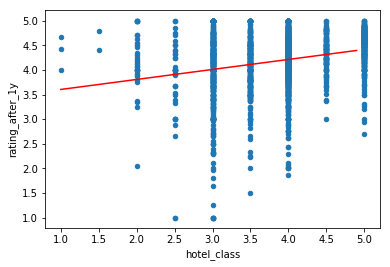

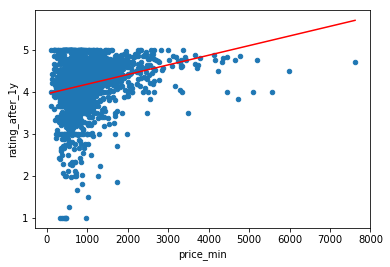

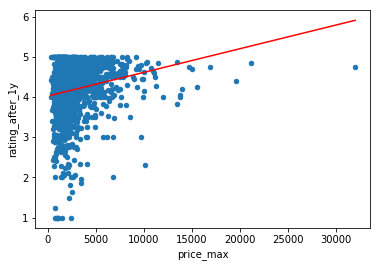

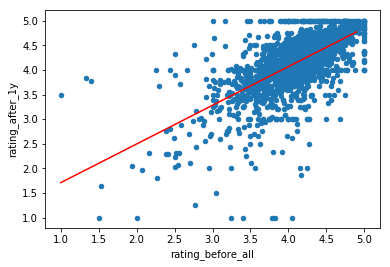

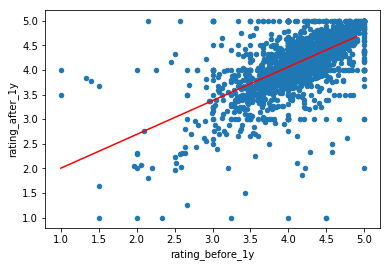

In [16]:
for feature in ["hotel_class", "price_min", "price_max", "rating_before_all", "rating_before_1y"]:
    # scatter plot
    ax = data.plot(kind="scatter", x=feature, y="rating_after_1y")

    # line of best fit (polynomial of degree 1).
    w1, w0 = np.polyfit(data[feature], target, deg=1)

    # plot line of best fit
    rng = np.arange(np.min(data[feature]), np.max(data[feature]), 0.1)
    ax.plot(rng,[w0+w1*x for x in rng], color="red")

Scatter plots show that the features picked (hotel class, minimum price per night, maximum price per night, rating_before_all, rating_before_1y) all have positive correlation with the rating (rating_after_1y) we are trying to predict.

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

from sklearn.linear_model import LinearRegression

clf = LinearRegression()
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
expected = y_test

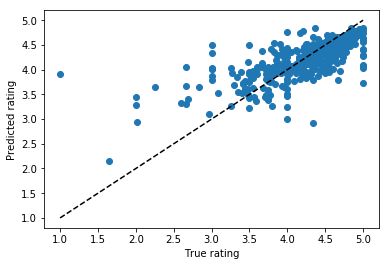

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(expected, predicted)
plt.plot([1, 5], [1, 5], '--k')
plt.xlabel('True rating')
plt.ylabel('Predicted rating')
plt.show()

In [19]:
from sklearn.metrics import r2_score

print("Model has a coefficient of determination, R^2, of {:.3f}.".format(r2_score(expected, predicted)))

Model has a coefficient of determination, R^2, of 0.497.


##### Which means that 49.7% of the changes in `rating_after_1y` can be explained by the selected features ("hotel_class", "price_min", "price_max", "rating_before_all", "rating_before_1y").

In [22]:
clf.predict([[4, 1100, 2800, 3.8, 3.9]])

array([3.93861616])

##### A 4-star hotel with price range of HKD 1100-2800, `rating_before_all` of 3.8 and `rating_before_1y` of 3.9 is predicted to have the TripAdvisor rating of 3.939 after launching handy for a year.